In [4]:
%matplotlib inline
import numpy as np
import pickle
import os
import math
from keras.layers import Input, Dense, Lambda
from keras.models import Model, load_model
from keras import objectives
from keras import backend as K
from sklearn.cluster import KMeans
#from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from bhtsne import tsne

In [5]:
# encoder/decoder network size
batch_size=500
original_dim=26621 # number of movies
intermediate_dim=600
latent_dim=200
epsilon_std=1.0

# encoder network
x=Input(batch_shape=(batch_size,original_dim))
h=Dense(intermediate_dim, activation='tanh')(x)
z_mean=Dense(latent_dim)(h)
z_log_var=Dense(latent_dim)(h)

In [6]:
def sampling(args):
    _mean,_log_var=args
    # does this mean we are modelling this is as a gaussian and not multinomial?
    epsilon=K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., std=epsilon_std)
    return _mean+K.exp(_log_var/2)*epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

In [7]:
# decoder network
h_decoder=Dense(intermediate_dim, activation='tanh')
x_bar=Dense(original_dim,activation='softmax')
h_decoded = h_decoder(z)
x_decoded = x_bar(h_decoded)

vae = Model(x, x_decoded)
weightsPath = "./tmp/weights.hdf5"
vae.load_weights(weightsPath)

In [8]:
x_test_matrix = pickle.load( open( "test_data.file", "rb" ) )
x_test_matrix = x_test_matrix.todense()  # 1s and 0s per user
x_test = np.squeeze(np.asarray(x_test_matrix))

In [9]:
encoder = Model(x, z_mean)
x_test_encoded = encoder.predict(x_test, batch_size=batch_size) 
print(x_test_encoded.shape) # should be 10000 X 200

(10000, 200)


In [10]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(x_test_encoded)
x_test_cluster_labels = kmeans.labels_

In [16]:
x_test_2_embedded = tsne(x_test_encoded.astype('float64'))

In [17]:
print(x_test_2_embedded.shape)

(10000, 2)


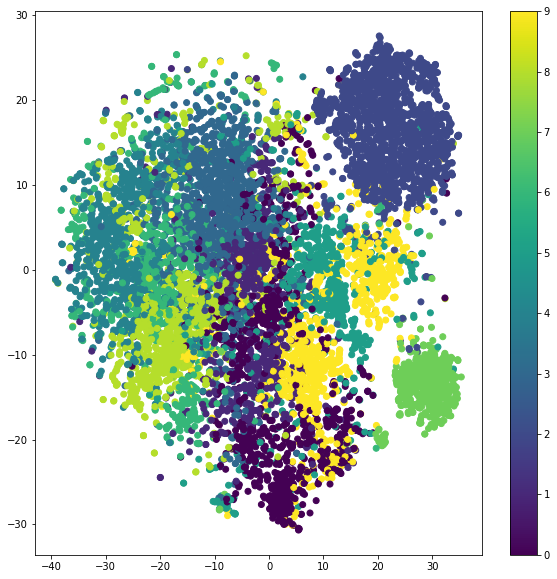

In [22]:
plt.figure(figsize=(10, 10))
plt.scatter(x_test_2_embedded[:, 0], x_test_2_embedded[:, 1], c=x_test_cluster_labels)
plt.colorbar()
plt.show()